In [14]:
!pip install -q xgboost scikit-learn pandas matplotlib seaborn shap

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [15]:
DATA_URL = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv"
df = pd.read_csv(DATA_URL)

print("Shape:", df.shape)
print(df.head())

# For your dataset, the target column is 'price'
target = "price"

Shape: (20000, 21)
           id             date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  1565930130  20141104T000000         4       3.25         3760      4675   
1  3279000420  20150115T000000         3       1.75         1460      7800   
2   194000575  20141014T000000         4       1.00         1340      5800   
3  2115510160  20141208T000000         3       1.75         1440      8050   
4  7522500005  20140815T000000         2       1.50         1780      4750   

   floors  waterfront  view  condition  ...  sqft_above  sqft_basement  \
0     2.0           0     0          3  ...        2740           1020   
1     1.0           0     0          2  ...        1040            420   
2     1.5           0     2          3  ...        1340              0   
3     1.0           0     0          3  ...        1440              0   
4     1.0           0     0          4  ...        1080            700   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15

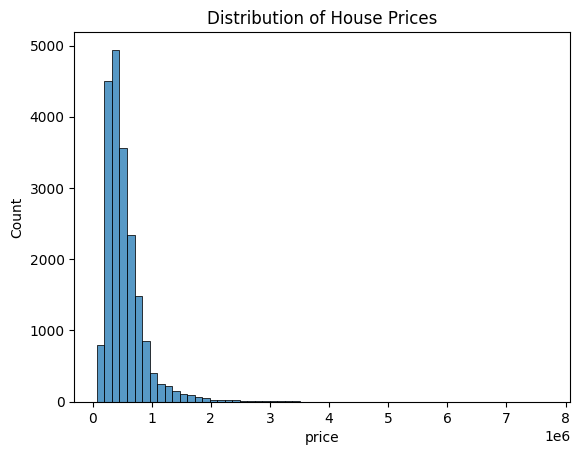

In [17]:
sns.histplot(df[target], bins=60, kde=False)
plt.title("Distribution of House Prices")
plt.show()

In [18]:
# Features that will help trees the most:
df["sqft_ratio"] = df["sqft_living"] / (df["sqft_lot"] + 1)
df["age"] = 2025 - df["yr_built"]
df["renovated"] = np.where(df["yr_renovated"] > 0, 1, 0) # Converts to a binary value (1 yes 0 no)

In [19]:
# List of numerical features
num_features = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors",
    "waterfront", "view", "condition", "grade", "sqft_above",
    "sqft_basement", "yr_built", "yr_renovated", "lat", "long",
    "sqft_living15", "sqft_lot15", "sqft_ratio", "age"
]

# List of categorical features
cat_features = ["zipcode"]

X = df[num_features + cat_features]
y = df[target]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train/Test shapes:", X_train.shape, X_test.shape)

Train/Test shapes: (16000, 20) (4000, 20)


In [21]:
# Fills in missing numerical values with the median of that column
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

# Fills in missing categorical values with the most frequent and encodes it to a numerical value
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
# Produces a 2D array that has numerical values for both categorical and numerical columns
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

In [49]:
# Creates the model using the pipeline
model = Pipeline([
    ("pre", preprocessor),
    ("model", XGBRegressor(
        n_estimators=250, # Number of trees
        learning_rate=0.07, # Shrinkage aka reduces risk of training on noise
        max_depth=6,
        random_state=42,
        verbosity=0
    ))
])

# Trains the preproccising and trans the XGBoost model on the transformed data
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'waterfront',
                                                   'view', 'condition', 'grade',
                                                   'sqft_above',
                                                   'sqft_basement', 'yr_built',
                                                   'yr_renovated', 'lat',
                                                   'long', 'sqft_living15',
                                                   'sqft_lot15', 'sqft_ratio',
                                                   'age']),
                                                 ('cat',
                                                  Pi...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.07,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=250, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [50]:
# Predicts from the trained regressor
y_pred = model.predict(X_test)

sse = np.sum((y_test - y_pred) ** 2) # Measures how far predictions are from actual values
mse = mean_squared_error(y_test, y_pred) # Takes the average of SSE
rmse = np.sqrt(mse) # Takes the square root of MSE which brings the error back to the same units as the target
r2 = r2_score(y_test, y_pred) # Measures how much variance in the target the model explains (Closer to 1 is best)

print(f"\nSSE: {sse:,.2e}")
print(f"MSE: {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")


SSE: 7.14e+13
MSE: 17,839,048,509.50
RMSE: 133,562.90
R²: 0.8817



Top 10 Feature Importances:


,0
grade,0.319895
sqft_living,0.114246
waterfront,0.072623
lat,0.054884
zipcode_98004,0.052108
zipcode_98039,0.050220
zipcode_98112,0.031400
long,0.029152
view,0.026325
sqft_living15,0.017798


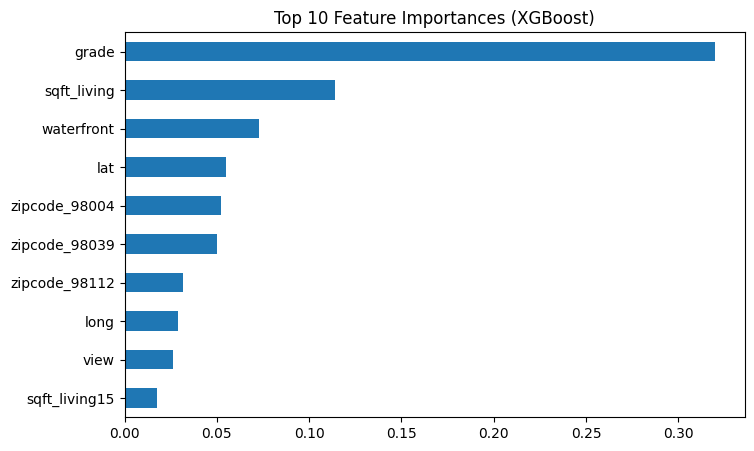

In [51]:
def get_feature_names(column_transformer):
    feature_names = [] # Intizializes the feature list

    # Finds the transformed column names and adds them back into the feature names list for presentation
    for name, trans, cols in column_transformer.transformers_:
        if name == "num":
            feature_names.extend(cols)
        elif name == "cat":
            ohe = trans.named_steps["onehot"] # Converts from numerical back to categorical name
            feature_names.extend(list(ohe.get_feature_names_out(cols)))
    return feature_names

# Gets feature names
feature_names = get_feature_names(model.named_steps["pre"])
# Gets the calculated importances from the trained model
importances = model.named_steps["model"].feature_importances_

# Sorts and puts into table
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nTop 10 Feature Importances:")
display(fi.head(10))

plt.figure(figsize=(8,5))
fi.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()

In [52]:
def predict_new_data(model, new_data_path, output_csv_name="team3-module3-predictions.csv"):
    # Load the new dataset
    new_df = pd.read_csv(new_data_path)
    print(f"Loaded new dataset with shape: {new_df.shape}")

    # Select the same feature columns used for training
    feature_columns = [
        "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors",
        "waterfront", "view", "condition", "grade", "sqft_above",
        "sqft_basement", "yr_built", "yr_renovated", "lat", "long",
        "sqft_living15", "sqft_lot15"
    ]

    # Recreate engineered features that way the model has the same values as the training data to work with
    new_df["sqft_ratio"] = new_df["sqft_living"] / (new_df["sqft_lot"] + 1)
    new_df["age"] = 2025 - new_df["yr_built"]
    new_df["renovated"] = (new_df["yr_renovated"] > 0).astype(int)
    feature_columns.extend(["sqft_ratio", "age"])
    cat_features = ["zipcode"]

    # Combine features for proper prediction setup
    X_new = new_df[feature_columns + cat_features]

    # Predict using the trained pipeline
    predictions = model.predict(X_new)

    # Create a new DataFrame for predictions only
    predictions_df = pd.DataFrame({
        "predictions": predictions
    })

    # Save only the predictions
    predictions_df.to_csv(output_csv_name, index=False)
    print(f"Predictions saved to '{output_csv_name}' (predicted_price column only)")

    # Display first few results
    display(predictions_df.head())

    return predictions_df

In [53]:
new_predictions = predict_new_data(
    model,
    "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv"
)

Loaded new dataset with shape: (1613, 20)
Predictions saved to 'team3-module3-predictions.csv' (predicted_price column only)


,predictions
0,3.880479e+05
1,8.796266e+05
2,1.183032e+06
3,2.099796e+06
4,7.022438e+05
